<a href="https://colab.research.google.com/github/AntoninoMusmeci/Lab2/blob/master/tesina_data_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast cancer classification

## Table of Contents
0. [Introduzione e descrizione del dataset](#0.-Introduzione)
1. [Tools utilizzati e funzioni](#1.-Tools-utilizzati)
2. [Analisi del Dataset](#2.-Analisi-Dataset)
3. [Preparazione del dataset](#3.-Preparazione)
    * 3.1 [Oversampling](#-o)
4. [Classificazione](#4.-Classification)
  * 4.1 [SVM](#-SVM)
     * 4.11 [linear SVM](#-SVMl)
     * 4.12 [RBF Kernel](#-SVMr)
  * 4.2 [Decision Tree](#-Tree)
  * 4.3 [Random Forest](#-Forest)

### 0. Introduzione
Il dataset usato in questa tesina è stato creato dal Dr.William H.Wolberg dell'universita del Wisconsin Hospital a Medison. Il dataset è stato creato usando campioni prelevati da pazienti con solid breast masses[10] da cui sono state poi estratte cytological features basedon a digital scan.
Il dataset contiene X record ognuno dei quali è formato da 11 colonne contenenti alcune caratteristiche delle cellule del corpo umano (e.g. forma e dimensione).

Nel dettaglio le features presenti nel database sono:

Sample code number: codice numerico intero utilizzato per identificare i pazienti

Clump Thickness: Indica come sono raggruppate le cellule, quelle benigne tendono a raggrupparsi in strati singoli mentre quelle maligne in strati multipli

Uniformity of Cell Size: le cellule cancerose variano in dimensione

Uniformity of Cell Shape: le cellule cancerose variano in dimensione

Marginal Adhesion: Le cellule normali tendono a restare unite mentre quelle cancerose tendono a perdere questa capacità. Una minore adesione può essere quindi un segno di malignità.

Single Epithelial Cell Size:Le cellule epiteliali notevolmente ingrandite possono essere maligne.

Bare Nuclei: Nuclei che non sono circondati dal citoplasma. Questo tipo di cellule sono tipiche dei tumori benigni

Bland Chromatin:La cromatina è la forma in cui gli acidi nucleici si trovano nella cellula.Nelle cellule tumorali la cromatina tende ad essere più grossolana

Normal Nucleoli: I nucleoli sono strutture presenti nel nucleo. Nelle cellule tumorali i nucleoli diventano più prominenti e talvolta ce ne sono di più.

Mitosi: divisione nucleare che produce due figlie cellulari identiche. La mitosi è più frequente nelle cellule cancerose

Class: indica se il cancro è benigno o maligno

L'obiettivo è quello di analizzare questo dataset e realizzare un classificatore che basandosi su alcune caratteristiche della cellula sia in grado di determinare se un tumore è benigno o maligno




### 1. Tools utilizzati e funzioni

In [ ]:
# import import_ipynb
# from ipynb.fs.full.myfunc import *
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from pylab import cm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# classification imports 
from sklearn import neighbors, model_selection, metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# Edit font, font size, and axes
mpl.rcParams['font.family'] = 'Metropolis'
pl.rcParams['font.size'] = 10
pl.rcParams['axes.linewidth'] = 2

# Generate 2 colors from the 'tab10' colormap
colors = cm.get_cmap('tab10', 2)

In [ ]:
""" FUNTIONS """
def check_balance(data):
    class1 = data[data == 1]
    class2 = data[data == -1]
    pl.hist(class1, color='red', width=0.5)
    pl.hist(class2, color='blue', width=0.5)
    pl.show()

def Apply_and_plot_Knn(Ks,X_train,y_train,X_test,y_test,nrow,ncols,test):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    fig, sub = plt.subplots(nrows = nrow, ncols = ncols,figsize=(5,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    accuracies =[]
    
    if np.ndim(sub) > 1:
        sub = sub.flatten()
    else:
        sub = [sub]
    
    for i,(k,ax) in enumerate(zip(Ks, sub)): 
        
        knn = KNeighborsClassifier(n_neighbors = k)
        #Train the model using the training sets
        knn.fit(X_train, y_train)
        #Predict the response for test dataset
        y_pred = knn.predict(X_test)

        accuracies.append(metrics.f1_score(y_test, y_pred))
    return accuracies

def plot_model(X,y,X_test,y_test,clf,ctype,title,ax):
    # create a mesh to plot in
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

    clf.fit(X, y) 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    #plt.figure()
    #plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
   
    # Plot also the training points
    ax.scatter(X_test[:,0], X_test[:,1],c=y_test,  cmap=plt.cm.coolwarm,
                edgecolor='k', s=20 )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Clump Thickness')
    plt.ylabel('Uniformity of Cell Shape')
    plt.xticks(())
    plt.yticks(())
    ax.set_title(title)

In [ ]:

def SVM_C_Gamma_Kfold(kernel, C_list, Gamma_list, X_train, Y_train, kfold):
    
    models = [] # list of all the different SVM that we had trained
    
    highest_accuracy = -1 # the highest accuracy found
    
    hyperparameters = np.empty(shape=(len(C_list), len(Gamma_list))) 

    for c in C_list:
        for gamma in Gamma_list:

            if PRINT == True:
                print("Fit and predict for RBF SVM with C =", c, "and Gamma =", gamma)
            
            clf = svm.SVC(C = c, gamma=gamma, kernel=kernel)
            scores = cross_val_score(clf,X_train, Y_train, cv=kfold, scoring = 'f1')
            
            
            accuracy = scores.mean()
            
            if PRINT == True:
                print("Mean accuracy of: %.3f" % accuracy, "\n")
    
            if(accuracy > highest_accuracy): 
                highest_accuracy = accuracy
    
            hyperparameters[C_list.index(c), Gamma_list.index(gamma)] = accuracy # save accuracy 

    return models, hyperparameters, highest_accuracy

def Find_BestHyperparameters(hyperparameters,C_list,Gamma_list,highest_accuracy) :
    
    C_bests_list = []
    Gamma_bests_list = []

    for c in C_list:
        for gamma in Gamma_list:
            if(hyperparameters[C_list.index(c), Gamma_list.index(gamma)] == highest_accuracy): 
                print("-> C=", c, ", Gamma=", gamma, "accuracy ", highest_accuracy)
                C_bests_list.append(c) # get all the C values that gave maximum accuracy
                Gamma_bests_list.append(gamma) # and corresponding gamma


    C_best = min(C_bests_list)

    Gamma_best = Gamma_bests_list[C_bests_list.index(C_best)]
    
    return  C_best,Gamma_best
def plot_scores(value,accuracies,axes_name,scale):
    plt.ylabel('f1-score')
    plt.xlabel(axes_name)
    plt.xticks(np.array(value))
    
    plt.plot(value,accuracies,'bo-')
    if scale == 1:
        plt.xscale('log')
    plt.grid(axis='y')
    plt.show()

In [ ]:
def SVM(X,y,X_test_a,y_test_a,kernel,C, Gamma_best):
    linearSVM = svm.SVC(C = C,gamma=Gamma_best,kernel=kernel)
    linearSVM.fit(X, y) # fit on training data
    Y_pred = linearSVM.predict(X_test_a) # predict evaluation data
    score = f1_score(y_test_a, Y_pred, pos_label= -1)
    print("C =", C) 
    print("---> Score = %.2f" % score)
    return linearSVM, score

## Analisi del dataset

Il dataset è fornito con un formato csv quindi facilmente legibile utilizzando la libreria pandas.
pandas ci permette di visualizzare il dataset in formato tabulare e di mostrare alcune informazioni statistiche sul dataset. 
Possiamo vedere che le features dalla seconda alla nona assumono i valori compresi tra 1 e 10  quindi viene utilizzata la stessa scala per tutti i valori e non è necessario effettuare ulteriori normalizzazioni prima di procedere con l'analisi. 
Vediamo inoltre che l'attributo class assume il valore 2 se il cancro è benigno o valore 4 se maligno
Per semplicità modifico i nomi di alcuni attributi e converto il valore della classe in 1, -1

In [ ]:
# load the dataset
dataset_url = "https://raw.githubusercontent.com/AntoninoMusmeci/Breast-Cancer-Coimbara-Data-Set/master/breast-cancer-wisconsin.data?token=ALZYAINTQGXBM24BW4XTIALAEJVYC"
df = pd.read_csv(dataset_url)

features = ["Sample Number","Clump Thickness", "Uniformity Size", "Uniformity Shape", "Adhesion", "Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", 
"Mitoses", "Class"]
df.columns = features

print("Il dataset ha %d righe e %d colonne." % df.shape)

# Label conversion in -1 and 1
di = {2: 1, 4: -1 }
df.replace({'Class': di}, inplace=True)

Il dataset ha 698 righe e 11 colonne.


In [ ]:
df.head()

,Sample Number,Clump Thickness,Uniformity Size,Uniformity Shape,Adhesion,Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,1
1,1015425,3,1,1,1,2,2,3,1,1,1
2,1016277,6,8,8,1,3,4,3,7,1,1
3,1017023,4,1,1,3,2,1,3,1,1,1
4,1017122,8,10,10,8,7,10,9,7,1,-1


In [ ]:
df.describe()

,Sample Number,Clump Thickness,Uniformity Size,Uniformity Shape,Adhesion,Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.980000e+02,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,1.071807e+06,4.416905,3.137536,3.210602,2.809456,3.217765,3.438395,2.869628,1.590258,0.309456
std,6.175323e+05,2.817673,3.052575,2.972867,2.856606,2.215408,2.440056,3.055004,1.716162,0.951596
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
25%,8.702582e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,-1.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000
75%,1.238354e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


Nel dataset potrebbero esserci dei valori mancanti. Controllo la presenza di valori non numerici

In [ ]:
# # check for null values in the dataset
print(df.shape)
df = (df.drop(features,axis=1)).join(df[features].apply(pd.to_numeric, errors='coerce'))
df = df[df[features].notnull().all(axis=1)]
print("Data shape without null values")
df = df.iloc[:, 1:11]
print(df.shape)

(698, 11)
Data shape without null values
(682, 10)


Come possiamo vedere il dataset contiene 16 valori mancanti tutti corrispondenti a alla colonna "bare nuclei size"
Rimpiazzare i valori mancanti potrebbe non essere una buona idea vista la natura del dataset. Infatti potrebbe non esserci nessuna correlazione tra il valore di dimensione della singola cellula e la media della dimensione delle altre cellule
Ho scelto quindi di rimuovere dal dataset le istanze relative ai valori mancanti 
Rimuovo dal dataset anche la prima colonna "Sample number" che rappresenta l'identificativo del paziente e non è di utilità per l'analisi

In [ ]:
#Description of the dataset

#how many cases are included in the dataset
length = len(df)
#how many features are in the dataset
features = df.shape[1]-1

# Number of malignant cases
malignant = len(df[df['Class']==-1])

#Number of benign cases
benign = len(df[df['Class']==1])

#Rate of malignant tumors over all cases
rate = (float(malignant)/(length))*100

print ("There are "+ str(len(df))+" cases in this dataset")
print ("There are {}".format(features)+" features in this dataset")
print ("There are {}".format(malignant)+" cases diagnosed as malignant tumor")
print ("There are {}".format(benign)+" cases diagnosed as benign tumor")
print ("The percentage of malignant cases is: {:.4f}%".format(rate))

There are 682 cases in this dataset
There are 9 features in this dataset
There are 239 cases diagnosed as malignant tumor
There are 443 cases diagnosed as benign tumor
The percentage of malignant cases is: 35.0440%


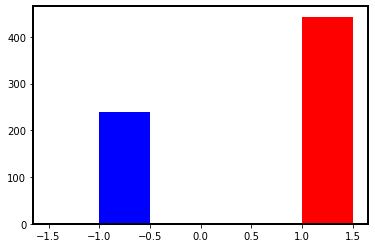

In [ ]:
len(df[df["Class"] == -1])
len(df[df["Class"] == 1])
checkClassBalance(df["Class"])


Come possiamo vedere il dataset è sbilanciato perchè ci sono più dati relativi a tumori benigni che maligni. Questo potrebbe essere un problema per molti algoritmi di classificazione.

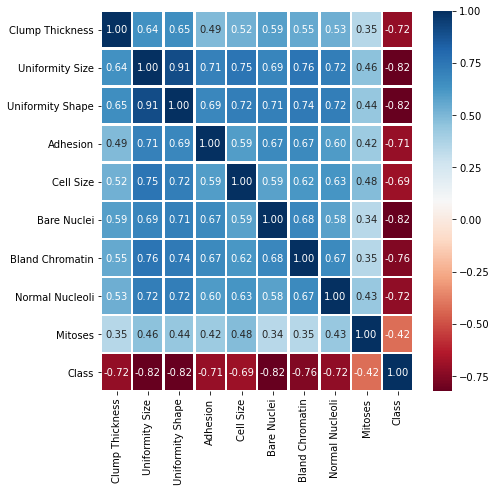

In [ ]:
correlation =  df.corr()
pl.figure(figsize = (7,7))
sns.heatmap( correlation,annot = True,fmt = '.2f',linewidths = 1.5, cmap = 'RdBu')
pl.show()

Tramite la matrice di correlazione possiamo vedere che in generale la correlazione dei valori è buona, il valore meno correlato con la classe è quello relativo alla mitosi.
Possiamo vedere anche che c'è una forte correlazione tra alcuni attributi e in particolare la  correlazione è molto alta tra Uniformity Shape e Uniformity Size.
Possiamo quindi scartare uno di questi due valori

In [ ]:
df.drop('Uniformity Size', axis=1, inplace=True)

## 3. Preparazione del dataset 

Per effettuare la nostra analisi dobbiamo dividere il nostro dataset in un train set per allenare il classificatore e un test set utilizzato alla fine per valutare l'effettiva "Accuratezza del modello". Per farlo utilizzo la funzione messa a disposizione dalla libreria scikit-learn che permette di ottenere una divisione casuale delle istanze in train e test.

In [ ]:
target = df.columns[8:9]
X = df[df.columns[0:8]] #our features
y = df[target] #our dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(len(X_train), len(X_test))

477 205


### 3.1 oversampling

Una possibile soluzione al problema dei dati non bilanciati è quella di sovra-campionare il dataset con una tecnica chiamata <b>SMOTE</b>(Synthetic Minority Over-sampling Technique).
SMOTE prende un elemento del dataset della classe minoritaria e considera i $k$ elementi più vicini nello spazio delle feature. Per creare un nuovo dato viene preso il vettore tra uno di questi $k$ vicini e il dato corrente, questo vettore viene  moltiplicato per un numero casuale tra $0$ e $1$ e aggiunto al dato corrente creando un nuovo dato sintetico


In [ ]:
sm = SMOTE(k_neighbors=7, random_state=50)
X_train, y_train = sm.fit_sample(X_train, y_train)

print('X_train after SMOTE: ', X_train.shape)
print('y_train after SMOTE : ', y_train.shape)
print('X_test:', X_test.shape)
print('y_test: ', y_test.shape)


X_train after SMOTE:  (614, 8)
y_train after SMOTE :  (614, 1)
X_test: (205, 8)
y_test:  (205, 1)


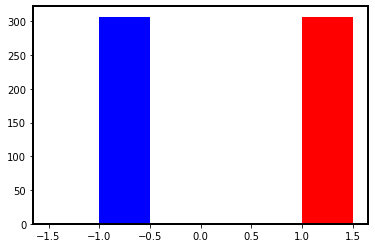

In [ ]:
checkClassBalance(y_train)

Come mostrato nella figura precedente, il trainset è stato bilanciato e adesso contiene lo stesso numero di istanze per la classe
positiva e per quella negativa. Prima di procedere con la classificazione suddivido ulteriormente il trainset per ottenere un validation set
da utilizzare per la validazione dei parametri dei modelli

In [ ]:
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=2/7, random_state=42)

Per analizzare correttamente i risultati dobbiamo considerare che per questo tipo di applicazioni oltre che avere un'elevata accuratezza è importante chel il modello trovi il minor numero possibile di falsi-negativi quando classifichiamo un cancro maligno, perchè classificare erroneamente un cancro maligno come benigno porterebbe ad un ritardo nella corretta diagnosi. 

Per questo motivo nell'analisi seguente ho deciso di puntare l'attenzione sui valori di precision e recall più che sull'accuratezza totale del modello.

La precisione è il rapporto tra il numero delle previsioni corrette di un evento (classe) sul totale delle volte che il modello lo prevede.

Il richiamo (recall) o sensibilità misura la sensibilità del modello. È il rapporto tra le previsioni corrette per una classe sul totale dei casi in cui si verifica effettivamente.



In [ ]:
result_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])

## 4. Classificazione 

### 4.1 Suppport vector machine(SVM)

Support Vector Machine (SVM) è a discriminative classificatore definito da un iperpiano separatore. L'obiettivo del classificatore SVM è quello di trovare un "buon" iperpiano separatore, dove la buona separazione è ottenuta scegliendo l'iperpiano che ha la distanza più grande rispetto ai dati di "training" di ogni classe.

Visto che nelle applicazioni reali i dati sono spesso accompagnati da rumore e spesso non sono linearmente separabili, la condizione di ottimalità per l'ìperpiano può essere rilassata includendo degli altri parametri
 

$$y_i ({\bf x}_i^T{\bf w} +b) \ge 1-\xi_i,\;\;\;(i=1,\cdots,m)$$

For minimum error, $\xi_i \ge 0$ should be minimized as well as $\vert\vert{\bf w}\vert\vert$, and the objective function becomes:


  \begin{eqnarray}
&	\mbox{minimize} & {\bf w}^T {\bf w}+C\sum_{i=1}^m \xi_i^k
	\nonumber \\
&	\mbox{subject to} & y_i ({\bf x}_i^T {\bf w}+b) \ge 1-\xi_i,
	\;\;\;\mbox{and}\;\;\;\xi_i \ge 0;\;\;\;(i=1,\cdots,m)
	\nonumber
\end{eqnarray}


Il parametro $C$ è un parametro di regolarizzazione the controlla il trade-off tra la massimo margine e minimo errore durante il training. Il parametro $C$ indica al classificatore SVM quanto si vuole evitare di classificare erroneamente un dato del training set. Per grandi valori di C verrà scelto un piccolo margine se l'iperpiano fa un lavoro migliore nel classificare correttamente tutti i punti. Viceversa, per piccoli valori di C verrà scelto un iperpiano separatore con un largo margine anche se quell'iperpiano classifica in modo errato più punti

#### 4.11 Linear SVM 

In [ ]:
C = [0.001, 0.01, 0.1, 1, 10, 100,1000]

In [ ]:
models =[]
scores = []
for c in C:
    model, score = SVM(X_train,y_train,X_val,y_val,'linear',c,'auto')
    models.append(model)
    scores.append(score)

C = 0.001
---> Score = 0.98
C = 0.01
---> Score = 0.97
C = 0.1
---> Score = 0.98
C = 1
---> Score = 0.98
C = 10
---> Score = 0.98
C = 100
---> Score = 0.98
C = 1000
---> Score = 0.98


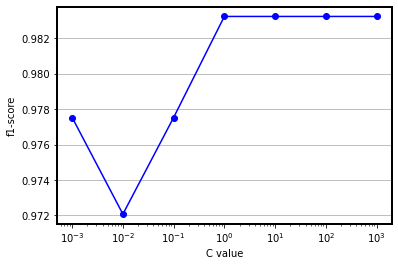

In [ ]:
plot_scores(C,scores ,'C value',1)

C = 1
---> Score = 0.96
0.9635036496350365


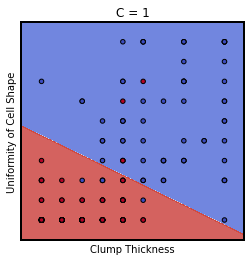

In [ ]:
from sklearn.base import clone
ind = np.argmax(accuracies)
best_C = C[ind]
best_clf,a = SVM(pd.concat([X_train,X_val]),pd.concat([y_train,y_val]),X_test,y_test,'linear',best_C,'auto')


svm_pred = best_clf.predict(X_test)
svm_acc = accuracy_score(svm_pred, y_test)
svm_prec = precision_score(svm_pred, y_test,pos_label= -1)
svm_sensitivity = recall_score(svm_pred, y_test,pos_label= -1)
svm_f1 = f1_score(svm_pred, y_test, pos_label= -1)
result_metrics.loc["Linear SVM"] = [svm_acc, svm_prec, svm_sensitivity, svm_f1]

fig, sub = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))
plot_model(pd.concat([X_train,X_val]).to_numpy()[:,:2],pd.concat([y_train,y_val]).to_numpy()[:,0],X_test.to_numpy()[:,:2],y_test.to_numpy()[:,0],clone(best_clf),'coolwarm',"C = " + str(C[ind]),sub)

#### 4.12 RBF Kernel 

La funzione del Kernel è di prendere un dato come input e trasformarlo nella forma richiesta. La funzione Kernel ritorna il prodotto scalare tra due punti nello spazio delle feature adatto con un piccolo costo computazionale anche per spazi con elevate dimensioni

 

Utiliziamo il kernel RBF, che è uno dei più usati, invece di quello lineare  
 $$  K(x,x′)=exp(\lambda||x−x′||^2) $$

Come per il caso lineare, valutiamo il modello sul validation set per ogni valore $C$ e scegliamo per $C$ il valore che da il punteggio più alto


In [ ]:
models_rbf = []
accuracies_rbf = []

for c in C:
    model_rbf, accuracy_rbf = SVM(X_train,y_train,X_val,y_val,'rbf',c,'auto')
    models_rbf.append(model_rbf)
    accuracies_rbf.append(accuracy_rbf)

C = 0.001
---> Score = 0.00
C = 0.01
---> Score = 0.95
C = 0.1
---> Score = 0.95
C = 1
---> Score = 0.96
C = 10
---> Score = 0.97
C = 100
---> Score = 0.97
C = 1000
---> Score = 0.97


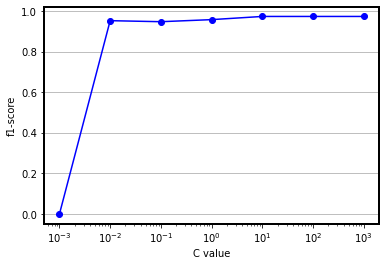

In [ ]:
plot_scores(C,accuracies_rbf,'C value',1)

C = 10
---> Score = 0.95


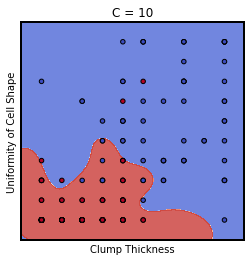

In [ ]:
from sklearn.base import clone
ind = np.argmax(accuracies_rbf)
best_C = C[ind]
best_clf,a = SVM(pd.concat([X_train,X_val]),pd.concat([y_train,y_val]),X_test,y_test,'rbf',best_C,'auto')



svm_pred = best_clf.predict(X_test)
svm_acc = accuracy_score(svm_pred, y_test)
svm_prec = precision_score(svm_pred, y_test,pos_label= -1)
svm_sensitivity = recall_score(svm_pred, y_test,pos_label= -1)
svm_f1 = f1_score(svm_pred, y_test, pos_label= -1)
result_metrics.loc["rbf Kernel SVM"] = [svm_acc, svm_prec, svm_sensitivity, svm_f1]
fig, sub = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))
plot_model(pd.concat([X_train,X_val]).to_numpy()[:,:2],pd.concat([y_train,y_val]).to_numpy()[:,0],X_test.to_numpy()[:,:2],y_test.to_numpy()[:,0],clone(best_clf),'coolwarm',"C = " + str(C[ind]),sub)

In [ ]:
C_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 

Gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000] 

X_train_Kfold = np.concatenate((X_train, X_val))
y_train_Kfold = np.concatenate((y_train,y_val))


models, hyperparameters, highest_accuracy = SVM_C_Gamma_Kfold('rbf', C_list, Gamma_list, 
                     X_train_Kfold, y_train_Kfold, 5) 

-> C= 10 , Gamma= 0.001 accuracy  0.975195675832438


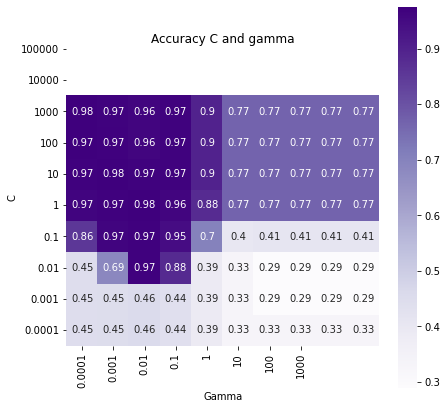

In [ ]:
plotHeat(hyperparameters,C_list, Gamma_list)
C_best,Gamma_best = Find_BestHyperparameters(hyperparameters,C_list,Gamma_list,highest_accuracy) 

La heatmap sopra mostra l'F1_score calcolato sul validation set per ogni coppia C e Gamma. C'è una regione della heatmap popolata da valori elevati. Possiamo vedere che per elevati valori di Gamma e C il classificatore non si comporta bene mentre le prestazioni migliorano all'aumento di C e al diminuire di Gamma

Selecting as best Hyperparameters: C= 10 , Gamma= 0.001
C = 10
---> Score = 0.96


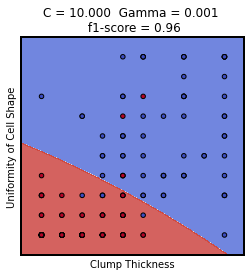

In [ ]:
print("Selecting as best Hyperparameters: C=", C_best, ", Gamma=", Gamma_best)
best_clf,accuracy =SVM(X_train_Kfold,y_train_Kfold,X_test,y_test,'rbf',C_best,Gamma_best)


svm_pred = best_clf.predict(X_test)
svm_acc = accuracy_score(svm_pred, y_test)
svm_prec = precision_score(svm_pred, y_test,pos_label= -1)
svm_sensitivity = recall_score(svm_pred, y_test,pos_label= -1)
svm_f1 = f1_score(svm_pred, y_test, pos_label= -1)

result_metrics.loc["rbf Kernel gridSearch SVM"] = [svm_acc, svm_prec, svm_sensitivity, svm_f1]
fig, sub = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))
plot_model(X_train_Kfold[:,:2],y_train_Kfold,X_test.to_numpy()[:,:2],y_test.to_numpy()[:,0],clone(best_clf),
           'coolwarm',"C = %.3f " % C_best + " Gamma = %.3f " % Gamma_best + "\n f1-score = %.2f" % accuracy,sub)

### 4.2 Decision Tree
Decision Tree è un modello molto comune per la classificazione. In questo contesto un modello di tipo decision tree è descritto da una struttura ad albero dove i nodi foglia rappresentano la classificazione mentre le ramificazioni rappresentano le "decisioni" effettuate che portano a queste classificazioni. Ogni nodo interno rappresenta una scelta su un' attributo del dataset e divide quindi il dataset in sottoinsiemi
Uno dei parametri che può essere utile definire è la profondità massima dell'albero in quanto questa non è collegata direttamente all'accuratezza del modello, se l'albero cresce troppo in dimensioni allora aumenta la complessita computazionale senza che ci siano miglioramenti dal punto di vista dell'accuratezza del modello

Ad ogni passo l'algoritmo per costruire l'albero sceglie un attributo su cui effettuare la divisione dell'insieme di elementi rimanenti. Per la scelta dell'attributo esistono diverse metriche. Le metriche più spesso utilizzate sono l'indice Gini e l'Entropia


L'indice Gini è calcolato come :$$ GI(t) = 1-\sum_{j=1}^k p(j|t)^2$$The L'Entropia è calcolata come:$$ Entropy(t) = -\sum_{j=1}^k p(j|t)log_2(p(j|t))$$$\forall \text{ nodo } t$, dove $p(j|t)$ è la frequenza relativa della classe $j$ al nodo $t$.

In [ ]:
X_train = X_train_Kfold
y_train = y_train_Kfold

In [ ]:
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
## Gini criterion
tree_Gini = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = 42), parameters, 
                         scoring = make_scorer(f1_score, greater_is_better=True,  pos_label= -1))
tree_Gini = tree_Gini.fit(X_train, y_train)
tree_Gini_pred = tree_Gini.predict(X_test)
tree_acc = accuracy_score(tree_Gini_pred, y_test)
tree_preci = precision_score(tree_Gini_pred, y_test, pos_label= -1)
tree_sensitivity = recall_score(tree_Gini_pred, y_test, pos_label= -1)
tree_f1 = f1_score(tree_Gini_pred, y_test, pos_label= -1)
result_metrics.loc["Tree Gini"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
print("The best parameters for Gini Decision Tree are %s with a score of %0.2f" % (tree_Gini.best_params_, tree_Gini.best_score_))
result_metrics.loc["Tree Gini"]

The best parameters for Gini Decision Tree are {'max_depth': 6} with a score of 0.96


Accuracy       0.956098
Precision      0.898551
Sensitivity    0.968750
F1 Score       0.932331
Name: Tree Gini, dtype: float64

In [ ]:
# Decision Tree

depth = np.arange(4, 20) # for trees and forests
parameters = {'max_depth': depth}

## Entropy criterion
tree_Entropy = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42), parameters,
                            scoring = make_scorer(f1_score, greater_is_better=True,  pos_label= -1))
tree_Entropy = tree_Entropy.fit(X_train, y_train)
tree_Entropy_pred = tree_Entropy.predict(X_test)
tree_acc = accuracy_score(tree_Entropy_pred, y_test)
tree_preci = precision_score(tree_Entropy_pred, y_test, pos_label= -1)
tree_sensitivity = recall_score(tree_Entropy_pred, y_test, pos_label= -1)
tree_f1 = f1_score(tree_Entropy_pred, y_test, pos_label= -1)
result_metrics.loc["Tree Entropy"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
print("The best parameters for Entropy Decison Tree are %s with a score of %0.2f" % (tree_Entropy.best_params_, tree_Entropy.best_score_))
result_metrics.loc["Tree Entropy"]

The best parameters for Entropy Decison Tree are {'max_depth': 4} with a score of 0.97


Accuracy       0.970732
Precision      0.942029
Sensitivity    0.970149
F1 Score       0.955882
Name: Tree Entropy, dtype: float64

Utilizzando l'indice Gini come criterio otteniamo un punteggio di 0.96 con una profondita massima di 6 mentre utilizzando l'entropia otteniamo un punteggio di 0.97 con una profondità massima dell'albero  di 4


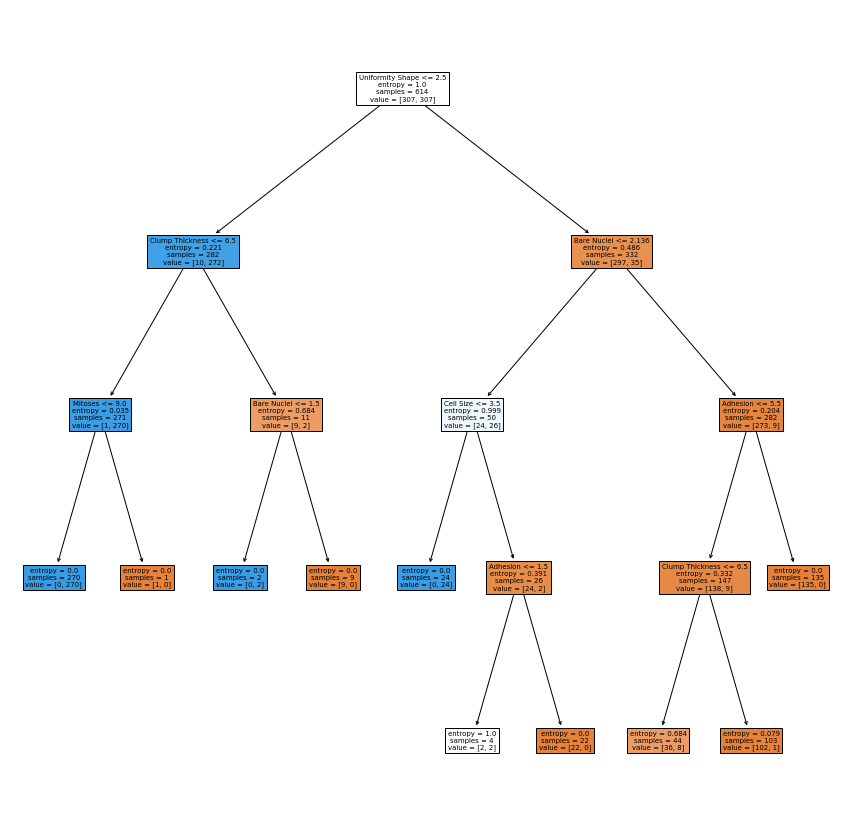

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42,max_depth=4)
clf = clf.fit(X_train, y_train)
pl.figure(figsize = (15,15))
tree.plot_tree(clf, filled = True, feature_names = df.columns[0:8])
pl.show()

### 4.3 Random forest
Come suggerisce il nome,Random Forest è un classificatore ottenuto usando parallelamente diversi Decision Tree allo stesso momento. L'idea è quella di generare diversi alberi utilizzando diversi sottoinsiemi del dataset e poi effettuare le decisioni a maggioranza. E' un modello che viene spesso utilizzato per cercare di minimizzare un possibile l'overfitting durante la fase di training quando si utilizzano Decision Tree
Anche in questo caso utilizzo l'Entropia e l'indice Gini come criteri per generare gli alberi.

In [ ]:
# Random forest
parameters = {'max_depth': depth}

## Entropy criterion
forest_Entropy = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'entropy', 
                                                     random_state = 42), parameters, scoring = 'f1')
forest_Entropy = forest_Entropy.fit(X_train, y_train)
forest_Entropy_pred = forest_Entropy.predict(X_test)
forest_acc = accuracy_score(forest_Entropy_pred, y_test)
forest_prec = precision_score(forest_Entropy_pred, y_test,pos_label= -1)
forest_sensitivity = recall_score(forest_Entropy_pred, y_test,pos_label= -1)
forest_f1 = f1_score(forest_Entropy_pred, y_test,pos_label= -1)
result_metrics.loc["Forest Entropy"] = [forest_acc,forest_prec,forest_sensitivity,forest_f1]
print("The best parameters for Entropy Random forest are %s with a score of %0.2f" % (forest_Entropy.best_params_, forest_Entropy.best_score_))
result_metrics.loc["Forest Entropy"]

The best parameters for Entropy Random forest are {'max_depth': 6} with a score of 0.98


Accuracy       0.980488
Precision      0.971014
Sensitivity    0.971014
F1 Score       0.971014
Name: Forest Entropy, dtype: float64

In [ ]:
## Gini criterion
forest_Gini = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'gini', 
                                                  random_state = 42), parameters, scoring = 'f1')
forest_Gini = forest_Gini.fit(X_train, y_train)
forest_Gini_pred = forest_Gini.predict(X_test)
forest_acc = accuracy_score(forest_Gini_pred, y_test)
forest_preci = precision_score(forest_Gini_pred, y_test,pos_label= -1)
forest_sensitivity = recall_score(forest_Gini_pred, y_test,pos_label= -1)
forest_f1 = f1_score(forest_Gini_pred, y_test,pos_label= -1)
result_metrics.loc["Forest Gini"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
print("The best parameters for Gini Random forest are %s with a score of %0.2f" % (forest_Gini.best_params_, forest_Gini.best_score_))
result_metrics.loc["Forest Gini"]

The best parameters for Gini Random forest are {'max_depth': 6} with a score of 0.98


Accuracy       0.980488
Precision      0.971014
Sensitivity    0.971014
F1 Score       0.971014
Name: Forest Gini, dtype: float64

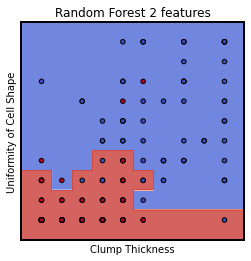

In [ ]:
fig, sub = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))
plot_model(X_train_Kfold[:,:2],y_train_Kfold,X_test.to_numpy()[:,:2],y_test.to_numpy()[:,0],clone(forest_Gini),
           'coolwarm','Random Forest 2 features',sub)


In [ ]:
result_metrics

,Accuracy,Precision,Sensitivity,F1 Score
Tree Gini,0.956098,0.898551,0.968750,0.932331
Tree Entropy,0.970732,0.942029,0.970149,0.955882
Forest Entropy,0.980488,0.971014,0.971014,0.971014
Forest Gini,0.980488,0.971014,0.971014,0.971014
